# Stochastic processes & wealth dynamics

## Introduction

In this lecture, we use random numbers and simulation to study stochastic processes and the dynamics of the wealth distribution:

1. We first turn our attention to autoregressive processes (or AR(1)), probably the most common linear processes 
    which  allows us to model persistence. 
2.  Next, we study wealth dynamics and cross-sectional wealth inequality in a model with a stochastic income process
    which is *uncorrelated* over time. We'll find that this model is unable to generate any wealth inequality.
3.  Next, we combine the two previous topics and study wealth dynamics if income follows a *persistent* AR(1) process.
    We'll find that this induces substantially more wealth inequality, but nowhere near as much as observed in the data.
4.  Finally, in the workshop we'll study wealth inequality if *returns on assets are stochastic*. We'll see that this 
    model can generate wealth inequality which is quantitatively much closer to the data.

We do not discuss wealth and income inequality in the data in this unit. See the corresponding 
[QuantEcon lecture](https://intro.quantecon.org/inequality.html)
for a Pythonic treatment of that topic.

While we derive some analytical results, the focus is on implementing numerical simulations using Python. However, the analytical results (where available) are useful to verify that our code produces the correct results.

In [1]:
# Enable automatic reloading of external modules
%load_ext autoreload
%autoreload 2

## AR(1) process

### Definition

In this section, we study a class of stochastic processes called AR(1) processes, i.e., autoregressive processes of order 1.
Please see the [QuantEcon lecture](https://intro.quantecon.org/ar1_processes.html) on AR(1) processes for a more comprehensive treatment of this topic using Python code.

In economics and finance, AR(1) processes are a simple way to model a stochastic process with some degree of persistence. This can be useful if we want to model
labor income, productivity (TFP), dividends, or similar.

The AR(1) process takes the form
$$
x_{t+1} = \mu + \rho x_t + \epsilon_{t+1}\,, \qquad \epsilon_{t+1} \stackrel{\text{iid}}{\sim} \mathcal{N}\left(0, \sigma^2\right)
$$
which gives rise to a time series of realizations $(x_t)_t$ for some initial value $x_0$ at $t=0$.
The error term $\epsilon_{t+1}$ is assumed to be independently and identically distributed (IID) which means that it is independent of all (past) realizations of $(x_s)_{s \leq t}$.

The process specified above has three parameters:

1.  $\mu$ controls the mean;
2.  $\rho$ controls the autocorrelation, i.e., the degree to which realizations are correlated with their immediate predecessor; and
3.  $\sigma^2$ governs the variance of the innovation or shock term $\epsilon_t$. It is commonly assumed that the innovation is drawn from a normal distribution which we'll maintain throughout this unit.

We will focus on AR(1) processes with $\rho \in (-1, 1)$ since this gives rise to a stationary distribution. A notable (nonstationary) case is $\rho = 1$ in which case such a process is no longer called an AR(1) but a "random walk" instead.

Note that the AR(1) by construction assumes that any persistence is only of order 1: Once we control for the realization $x_t$, there is no additional interdependence between $x_{t+1}$ and realizations further in the past.

#### Moments of the AR(1) process

As mentioned above, we maintain the assumption that $\rho \in (-1, 1)$ as then the AR(1) process is stationary. We won't be concerned with a formal definition of stationarity; for our purposes, we simply use the implication that in the long run, the distribution of realizations in the sequence $(x_t)_t$ converges to a (normal) distribution with a fixed mean and variance which are functions of the parameters $\mu$, $\rho$, and $\sigma^2$.

We can easily derive the mean and variance of this stationary distribution as follows:
Taking expectations on both sides of the AR(1) equation above, we have
$$
\mathbb{E}x_{t+1} = \mu + \rho \mathbb{E}x_t + \underbrace{\mathbb{E}\epsilon_{t+1}}_{=0}
$$
Since the AR(1) is assumed to be stationary, we must have that $\mathbb{E}x_{t+1} = \mathbb{E}x_{t}$. The above equation therefore implies that 
the unconditional mean of the AR(1) is 
$$
\mathbb{E}x_t = \frac{\mu}{1-\rho}
$$
An analogous derivation can be used to obtain the unconditional variance. Computing the variance of both sides, we have
$$
\text{Var}(x_{t+1}) = \text{Var}\left(\mu + \rho x_t + \epsilon_{t+1} \right)
    = \rho^2 \text{Var}(x_t) + \text{Var}(\epsilon_{t+1}) = \rho^2 \text{Var}(x_t) + \sigma^2
$$
where the last step follows since the innovations $\epsilon_{t+1}$ are independent of $x_t$.
With stationarity, we again must have $\text{Var}(x_{t+1}) = \text{Var}(x_{t})$ so that the above equation can be solved for the unconditional variance
$$
\text{Var}(x_t) = \frac{\sigma^2}{1-\rho^2}
$$
The stationary distribution of the AR(1) is therefore given by
$$
x_t \sim \mathcal{N}\left(\frac{\mu}{1-\rho}, \frac{\sigma^2}{1-\rho^2} \right)
$$

### Simulating an AR(1) process

Turning to more practical matters, we now want to simulate a time series of realizations from an AR(1) process for some given initial value $x_0$. The following function implements this simulation. Note that in addition to the AR(1) parameters, we write the function to accept an `rng` argument so that callers can pass in a Random number generator (RNG) instance used to perform the simulation. If no such `rng` argument is present, we create a fresh instance using a fixed seed.

In [2]:
import numpy as np

def simulate_ar1(x0, mu, rho, sigma, n, rng=None):
    """
    Simulates an AR(1) process.

    Parameters
    ----------
    x0 : float
        The initial value of the process.
    mu : float
        Intercept.
    rho : float
        The autoregressive parameter.
    sigma : float
        The standard deviation of the noise term.
    n : int
        The number of time periods to simulate.
    rng : Generator, optional
        Random number generator to use.

    Returns
    -------
    numpy.ndarray
        An array of length `n` containing the simulated AR(1) process.
    """

    # Create an array to store the simulated values
    x = np.zeros(n)

    # Set the initial value
    x[0] = x0

    # Create RNG instance
    if rng is None:
        rng = np.random.default_rng(seed=123)
        
    # Draw random shocks
    eps = rng.normal(0, sigma, n-1)

    # Simulate the AR(1) process
    for i in range(n-1):
        x[i+1] = mu + rho * x[i] + eps[i]

    return x

The code below fixes the AR(1) parameters and calls `simulate_ar1()` to simulate 100 periods for a given initial value.

In [3]:
# RNG instance with seed
seed = 1234
rng = np.random.default_rng(seed=seed)

# Initial value
x0 = 0.0

# Intercept 
mu = 0.0

# Autocorrelation parameter
rho = 0.9

# Standard deviation of the noise term
sigma = 0.1

# Number of periods to simulate
T = 100

# Simulate the AR(1) process
simulated_data = simulate_ar1(x0, mu, rho, sigma, T, rng)

We can plot this simulated time series as follows:

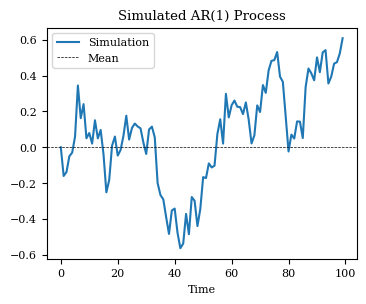

In [4]:
import matplotlib.pyplot as plt 

# Use default x-values (0, 1, 2, ..., T)
plt.plot(simulated_data, label='Simulation')
plt.xlabel('Time')
plt.title('Simulated AR(1) Process')
# Add unconditional mean
plt.axhline(mu/(1-rho), color='black', linestyle='--', lw=0.5, label='Mean')
plt.legend()

This of course is only one particular realization of 100 time periods which depends on the pseudo-random draws of the innovations $(\epsilon_t)_t$.
Below we repeat this sampling $N=20$ times to get vastly different realizations.

In [5]:
# Simulate 20 different sequences
N = 20

# Create an array to store the simulated values
data = np.zeros((N, T))

# Simulate the AR(1) process N times
for i in range(N):
    data[i, :] = simulate_ar1(x0, mu, rho, sigma, T, rng)

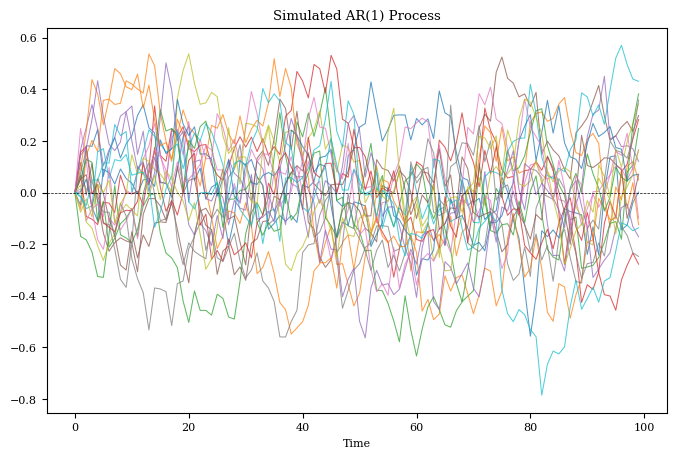

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(data.T, alpha=0.75, lw=0.75)
ax.set_xlabel('Time')
ax.set_title('Simulated AR(1) Process')
# Add unconditional mean
ax.axhline(mu/(1-rho), color='black', linestyle='--', lw=0.5, label='Mean')

<div class="alert alert-info">
<h3> Your turn</h3>

Let <i>µ = 1</i>, <i>ρ=0.95</i>, and <i>σ = 0.1</i>.
Using the function <tt>simulate_ar1()</tt>,
simulate 1,000,000 draws of <i>x<sub>t</sub></i> and verify that the unconditional mean and variance are close to the values given by the exact formulas above,
i.e., <i>E[x] = µ/(1-ρ)</i> and <i>Var(x) = σ<sup>2</sup> / (1-ρ<sup>2</sup>)</i>.
</div>

## Wealth dynamics

We now turn to wealth dynamics, and we'll study which type of stochastic processes can give rise to a realistic cross-sectional distribution of wealth ("cross section" refers to the distribution of households or individuals at one point in time). To this end, we'll explore wealth dynamics in the following scenarios:

1.  IID income shocks;
2.  Income which follows an AR(1) process; and
3.  Stochastic returns on wealth (covered in the workshop)

As we'll see, the first two scenarios are unable to generate realistic levels of wealth inequality.

Throughout the remaining sections, we abstract from general equilibrium considerations and model household choices in a simplified fashion.

Assume that each household index by $i$ enters a period $t$ with assets $a_{i,t}$ which include savings from the previous period, capital income earned on these savings, as well as labor income which is assumed to be paid out at the end of the period. Households consume $c_{i,t} \leq a_{i,t}$ out of these assets, and thus their wealth evolves according to
$$
a_{i,t+1} = R (a_{i,t} - c_{i,t}) + y_{i,t+1}
$$
where any resources that are not consumed are invested and earn a time-invariant gross return $R$.
We assume that households follow a rule of thumb and choose to save a fixed fraction $s$ of beginning-of-period assets, so
that consumption is $c_{i,t} = (1-s)a_{i,t}$. The above law-of-motion can thus be written as
$$
a_{i,t+1} = R s a_{i,t} + y_{i,t+1}
$$

### Wealth dynamics with stochastic IID income

We complement the law of motion for assets with the assumption that income received at the end of the period is identically and independently (IID) log-normally distributed (i.e., 
the natural logarithm of income is normally distributed):
$$
\log y_{i,t+1} \stackrel{\text{iid}}{\sim} \mathcal{N}\left(\mu_y, \sigma_y^2 \right)
$$
where $\mu_y$ is the mean of log income and $\sigma_y^2$ is its variance.

#### Analytical results (optional)

The following properties of the log-normal distribution are useful when deriving the stationary distribution of wealth. While we'll numerically simulate the dynamics of wealth, the results below can be used to verify that our simulation is correct.

For a log-normally distributed variable $X$ with 
$$
\log X \stackrel{\text{iid}}{\sim} \mathcal{N}\left(\mu, \sigma^2 \right)\;,
$$
its mean (expected value) *in levels* is given by
$$
\mathbb{E}X = e^{ \mu + \frac{1}{2}\sigma^2}
$$
and its variance is 
$$
\text{Var}(x) = \left( e^{\sigma^2} - 1 \right) e^{2 \mu + \sigma^2}
$$

We can use these formulas to derive the mean of the stationary wealth distribution implied by the above law-of-motion (LOM).
Taking expectations on both sides of the LOM equation, we see that 
$$
\mathbb{E}[a_{i,t+1}] = Rs \mathbb{E}[a_{i,t}] + \mathbb{E}[y_{i,t}]
$$
 Assuming that a stationary distribution exists, the cross-sectional mean wealth is the same in every period, and we must have $\mathbb{E}a_{i,t+1} = \mathbb{E}a_{i,t}$. It follows that
$$
\mathbb{E}[a_{i,t}] = \frac{\mathbb{E}[y_{i,t}]}{1 - Rs}
 = \frac{e^{\mu_y + \frac{1}{2}\sigma_y^2}}{1 - Rs}
$$
A similar reasoning can be used to obtain the variance of the stationary cross-sectional wealth distribution,
$$
\text{Var}(a_{i,t}) = \frac{\text{Var}(y_{i,t})}{1-(Rs)^2} = 
\frac{\left( e^{\sigma_y^2} - 1 \right) e^{2 \mu_y + \sigma_y^2}}{1-(Rs)^2}
$$

From the above equations we see that the parameters $R$ and $s$ have to satisfy 
the condition $R s < 1$, otherwise the mean and variance formulas
for the cross-sectional distribution of $a_{i,t}$ yield nonsensical results.

#### Simulating the wealth distribution

##### Parameters

To simulate the evolution of wealth, we assume that households save 75% of their beginning-of-period assets ($s=0.75$), and receive a 10% return on their investment ($R=1.1$). The variance of log income is set to $\sigma_y = 0.1$. Finally, we pick the mean of log income so that average income in levels is 1. This is achieved by setting
$$
\mu_y = -\frac{1}{2}\sigma_y^2
$$ 
Then it follows from the above formula that average income in levels is one:
$$
\mathbb{E}y_{i,t} = e^{\mu_y + \frac{1}{2}\sigma_y^2}
= e^{-\frac{1}{2}\sigma_y^2 + \frac{1}{2}\sigma_y^2}
= e^0 = 1
$$

As in previous lectures, we create a `Parameters` data class to store all model parameters:

In [7]:
# Parameters
from dataclasses import dataclass

@dataclass
class Parameters:
    s: float = 0.75                 # Exogenous savings rate
    R: float = 1.1                  # Gross return
    sigma_y: float = 0.1            # Standard deviation of log income
    mu_y: float = -sigma_y**2.0/2.0     # Mean of log income


In [8]:
# Create an instance of the Parameters class
par = Parameters()

Before proceeding with the wealth simulation, we confirm that the parameters satisfy the condition for a stationary wealth distribution discussed above:

In [9]:
# Check for finite mean and variance of stationary distribution
assert par.R * par.s < 1

Finally, we verify that the analytical unconditional mean of income is 1 as intended, and we compute the mean of the stationary wealth distribution.

In [10]:
# Mean of income 
y_mean = np.exp(par.mu_y + par.sigma_y**2/2)

# Mean of stationary distribution
a_mean = y_mean / (1 - par.s * par.R)

print(f'Mean income: {y_mean:.3f}')
print(f'Mean wealth: {a_mean:.3f}')

Mean income: 1.000
Mean wealth: 5.714


<div class="alert alert-info">
<h3> Your turn</h3>

Simulate 100,000 income draws of <i>y<sub>t</sub></i> and verify that the realizations have a mean of one.
</div>

##### Implementation

The following function implements the wealth simulation with an IID income process. The code proceeds in three main steps:

1. Draw all income realizations for all $N$ households and all $T$ periods and store them in a $T \times N$ array.
2. Set the initial assets for all households to the given value $a_0$.
3. Use the asset law-of-motion to simulate assets forward one period at a time.

In [11]:
def simulate_wealth_iid_income(par: Parameters, a0, T, N, rng=None):
    """
    Simulate the evolution of wealth over time if income is iid.

    Parameters
    ----------
    par : Parameters
    a0 : float
        Initial wealth.
    T : int
        Number of time periods to simulate.
    N : int
        Number of individuals to simulate.
    rng : numpy.random.Generator, optional
        A random number generator instance.

    Returns
    -------
    a_sim : numpy.ndarray
        A (T+1, N) array where each column represents the simulated wealth path of an household.
    """

    if rng is None:
        rng = np.random.default_rng(seed=seed)

    # Random draws of IID income
    log_y = rng.normal(loc=par.mu_y, scale=par.sigma_y, size=(T, N))

    # Income in levels
    y = np.exp(log_y)

    # Create array to store the simulated wealth paths
    a_sim = np.zeros((T+1, N))

    # Set initial value (identical for all households)
    a_sim[0] = a0

    # Simulate wealth forward, one period at a time
    for t in range(T):
        # Savings out of beginning-of-period assets
        savings = par.s * a_sim[t]
        # Next-period assets
        a_sim[t+1] = par.R * savings + y[t]

    return a_sim

##### Simulating a small sample

We first simulate the wealth trajectories for a cross section of $N=20$ households for 100 periods:

In [12]:
# Initial wealth (identical for all households)
a0 = 1.0
# Number of periods to simulate
T = 100
# Number of households to simulate
N = 20

# Create RNG instance
rng = np.random.default_rng(seed=1234)

# Simulate the wealth paths (result is an array of shape (T+1, N))
a_sim = simulate_wealth_iid_income(par, a0, T, N, rng)

# Mean of simulated time series
a_sim_mean = np.mean(a_sim, axis=1)

Next, we plot the simulated wealth trajectories and also add the mean of the stationary wealth distribution to the plot. 

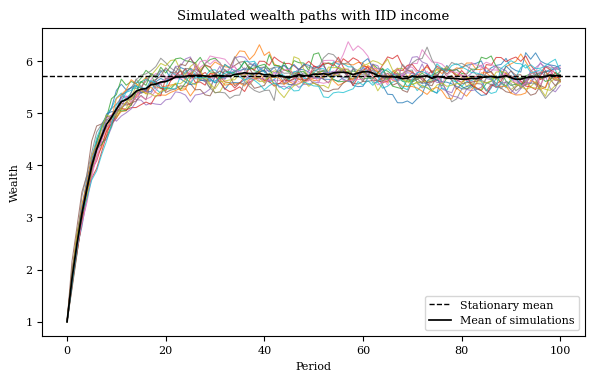

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(a_sim, alpha=0.75, lw=0.75)
ax.set_xlabel('Period')
ax.set_ylabel('Wealth')
ax.set_title('Simulated wealth paths with IID income')
# Add unconditional mean of wealth distribution
ax.axhline(a_mean, color='black', ls='--', lw=1, label='Stationary mean')
# Add average of simulated wealth paths
ax.plot(a_sim_mean, color='black', ls='-', lw=1.25, label='Mean of simulations')
ax.legend(loc='lower right')

The graph shows that after about 30 periods, the wealth distribution for each period is more or less centered around its stationary mean.

##### Simulating a large sample

The small sample simulated above is useful to visualize what is going on, but if we want to compute measures of wealth inequality, we need to base these on a larger cross section of households. We therefore repeat the exercise and simulate 100,000 households for 100 periods:

In [14]:
# Simulate larger sample
N = 100_000
T = 100

# Create RNG instance
rng = np.random.default_rng(seed=1234)

# Simulate the wealth paths (result is an array of shape (T+1, N))
a_sim = simulate_wealth_iid_income(par, a0, T, N, rng)

# Cross-sectional mean of simulated time series
a_sim_mean = np.mean(a_sim, axis=1)

# Cross-sectional variance of simulated time series
a_sim_var = np.var(a_sim, axis=1)

##### Comparing simulated to analytical moments

Before proceeding, it is instructive to compare the mean and variance of the simulated cross section to the analytical (exact) moments of the stationary wealth distribution. The module `lecture07_iid_income` contains function to compute the exact mean and variance:

In [15]:
from lecture07_iid_income import compute_wealth_mean, compute_wealth_var

# Compute analytical mean and variance
a_mean_exact = compute_wealth_mean(par)
a_var_exact = compute_wealth_var(par)

The following plot compares the simulated mean and variance to their analytical counterparts. As you can see, both the mean and the variance of the cross-sectional wealth distribution converge to their analytical counterparts after around 30 periods.

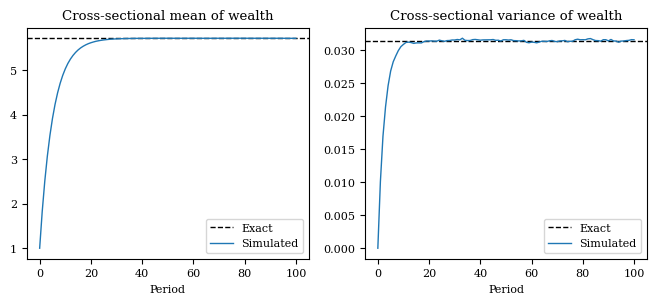

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

# Initial period for plotting (omit earlier periods to zoom in on convergence)
t_from = 0
xvalues = np.arange(t_from, T+1)

# Plot simulated vs. analytical mean
ax1.axhline(a_mean_exact, color='black', ls='--', lw=1, label='Exact')
ax1.plot(xvalues, a_sim_mean[t_from:], lw=1, label='Simulated')
ax1.set_xlabel('Period')
ax1.set_title('Cross-sectional mean of wealth')
ax1.legend(loc='lower right')

# Plot simulated vs. analytical variance
ax2.axhline(a_var_exact, color='black', ls='--', lw=1, label='Exact')
ax2.plot(xvalues, a_sim_var[t_from:], lw=1, label='Simulated')
ax2.set_title('Cross-sectional variance of wealth')
ax2.set_xlabel('Period')
ax2.legend(loc='lower right')

##### Measuring wealth inequality

With the simulated cross section of 100,000 households in hand, we can also compute measures of wealth inequality and compare the to data. Here we focus on the Gini coefficient, which we compute in the following function using the 
[definition for sorted arrays](https://en.wikipedia.org/wiki/Gini_coefficient#Alternative_expressions):

In [17]:
def gini(x):
    """
    Compute the Gini coefficient of an array.

    Parameters
    ----------
    x : numpy.ndarray
        An array of income, wealth, etc.

    Returns
    -------
    float
        The Gini coefficient.
    """

    # Sort the array
    x_sorted = np.sort(x)

    # The number of observations
    N = len(x)

    ii = np.arange(1, N+1)

    # Compute the Gini coefficient
    # Use Alternative Formula from Wiki for sorted arrays
    G = 2*np.sum(ii * x_sorted) / (N * np.sum(x_sorted)) - (N + 1) / N

    return G

To compute the Gini, we choose the last period of simulated panel (any other period would be fine as well as long as the wealth distribution has approximately converged to its stationary state).

In [18]:
# Select cross section from last simulated period
last_cross_section = a_sim[-1]

# Compute and print the Gini coefficient
G = gini(last_cross_section)
print(f'Wealth Gini coefficient: {G:.3f}')

Wealth Gini coefficient: 0.018


The result shows that the Gini coefficient for wealth is only around 0.02 in this scenario, whereas it is approximately 0.8 in countries such as the US. Thus the model presented here generates almost no wealth inequality. This is not overly surprising as the only source of heterogeneity in this economy are IID income shocks, which by construction don't give rise to persistent or large differences between households.

In the next section, we investigate how this changes if we allow for persistence in income.

<div class="alert alert-info">
<h3> Your turn</h3>

Change the parameter <i>σ<sub>y</sub></i> governing the volatility of income to <i>σ<sub>y</sub> = 0.5</i>
and rerun the code for the whole current section. What happens to average wealth in the economy and to the Gini coefficient?
</div>

### Wealth dynamics with persistent income

We have just demonstrated that IID income combined with a fixed savings rule generates almost no wealth inequality (this is also true if we allow households to choose an optimal savings rate).
We now augment the model from the previous section and introduce some persistence in income by modelling it as an AR(1):
$$
\begin{aligned}
\log y_{i,t+1} &= \mu_y + \rho \log y_{i,t} + \epsilon_{i,t+1} \\
\epsilon_{i,t+1} &\stackrel{\text{iid}}{\sim} \mathcal{N}\left(0, \sigma_{\epsilon}^2 \right)
\end{aligned}
$$
If income differences are persistent for longer periods of time, they should in principle induce larger differences in wealth holdings and thus move wealth inequality towards more realistic levels. In the remainder of this section, we investigate whether this the case.


#### Analytical results (optional)

With persistent income, we can still compute the mean of the stationary wealth distribution, but this is no longer possible for the variance. The reason is that unlike for the IID case, assets $a_{i,t}$ and income $y_{i,t+1}$ are no longer independent.

For the mean, we proceed in the same way as in the IID case:
Taking expectations on both sides of the law-of-motion for assets, we see that 
$$
\mathbb{E}[a_{i,t+1}] = Rs \mathbb{E}[a_{i,t}] + \mathbb{E}[y_{i,t}]
$$
Assuming that a stationary distribution exists, the cross-sectional mean wealth is the same in every period, and we must have $\mathbb{E}a_{i,t+1} = \mathbb{E}a_{i,t}$. It follows that
$$
\mathbb{E}[a_{i,t}] = \frac{\mathbb{E}[y_{i,t}]}{1 - Rs}
$$
which is the same expression as in the IID income case. Consequently, if we pick parameters such that mean income $\mathbb{E}y_{i,t}$ is the same as before, the wealth distribution has the same mean for the IID and the AR(1) income processes.

The expression for $\mathbb{E}y_{i,t}$ is now more complicated than in the IID case and depends on all the parameters
of the AR(1).
From the section on AR(1) processes, we know that the stationary distribution of $\log y_{i,t}$ is given by
$$
\log y_{i,t} \sim \mathcal{N}\left(\frac{\mu_y}{1-\rho}, \frac{\sigma_y^2}{1-\rho^2} \right)
$$
The mean of $y_{i,t}$ in levels then follows from the formula for log-normal random variables introduced earlier,
$$
\mathbb{E}[y_{i,t}] = \exp\left\{\frac{\mu_y}{1-\rho} + \frac{1}{2} \frac{\sigma_y^2}{1-\rho^2}\right\}
$$
As before, we don't need this results to simulate the wealth dynamics, but it is useful to confirm that our code is correct.

#### Simulating the wealth distribution

##### Parameters

For comparability with the previous section, we want to choose parameters such that $\mathbb{E}y_{i,t} = 1$,
which implies that we have to set
$$
\frac{\mu_y}{1-\rho}  = - \frac{1}{2} \frac{\sigma_y^2}{1-\rho^2}
\quad \Longrightarrow \quad
\mu = - \frac{1}{2} \frac{\sigma_y^2}{1+\rho}
$$
as then $\mathbb{E}y_{i,t} = e^0 = 1$.

We define a new `Parameters` data class since we have the additional parameter $\rho$. 
We set the persistence of log income to be high with $\rho = 0.95$.

In [19]:
# Parameters
from dataclasses import dataclass

@dataclass
class Parameters:
    s: float = 0.75                 # Exogenous savings rate
    R: float = 1.1                  # Gross return
    sigma_eps: float = 0.1          # Conditional standard deviation of log income
    rho: float = 0.95               # Persistence of log income
    mu_y: float = -sigma_eps**2.0/2.0/(1+rho)    # Intercept of log income


In [20]:
# Create an instance of the Parameters class
par = Parameters()

We verify that the analytical unconditional mean of income is 1 as intended, and we compute the mean of the stationary wealth distribution.

In [21]:
# Mean of income 
y_mean = np.exp(par.mu_y/(1-par.rho) + par.sigma_eps**2/2/(1-par.rho**2))

# Mean of stationary distribution
a_mean = y_mean / (1 - par.s * par.R)

print(f'Mean income: {y_mean:.3f}')
print(f'Mean wealth: {a_mean:.3f}')

Mean income: 1.000
Mean wealth: 5.714


<div class="alert alert-info">
<h3> Your turn</h3>

Simulate a time series of 10,000,000 income draws <i>y<sub>t</sub></i> and verify that the realizations have a mean of one.
</div>

##### Implementation

The following function implements the wealth simulation with an AR(1) income process. The code proceeds in five main steps:

1. Draw all AR(1) shock realizations for all $N$ households and all $T$ periods and store them in a $T \times N$ array.
2. Assume that all individuals start with the same income which corresponds to the unconditional mean of the AR(1).
3. Set the initial assets for all households to the given value $a_0$.
4. Use the AR(1) law-of-motion to simulate next-period income given current income.
5. Use the asset law-of-motion to simulate next-period assets.

In [22]:
def simulate_wealth_ar1_income(par: Parameters, a0, T, N, rng=None):
    """
    Simulate the evolution of wealth over time if income follows an AR(1).

    Parameters
    ----------
    par : Parameters
    a0 : float
        Initial wealth.
    T : int
        Number of time periods to simulate.
    N : int
        Number of individuals to simulate.
    rng : numpy.random.Generator, optional
        A random number generator instance.

    Returns
    -------
    a_sim : numpy.ndarray
        A (T+1, N) array where each column represents the simulated wealth path of a household.
    """

    if rng is None:
        rng = np.random.default_rng(seed=seed)

    # Random draws AR(1) innovations (epsilon)
    epsilon = rng.normal(loc=0, scale=par.sigma_eps, size=(T, N))

    # Compute mean log income
    log_y_mean = par.mu_y/(1-par.rho)

    # Assume that all individuals start with the same income
    log_y = np.full(N, fill_value=log_y_mean)

    a_sim = np.zeros((T+1, N))
    a_sim[0] = a0

    for t in range(T):
        # Savings out of beginning-of-period assets
        savings = par.s * a_sim[t]

        # Log income next period
        log_y = par.mu_y + par.rho * log_y + epsilon[t]

        # Next-period assets
        a_sim[t+1] = par.R * savings + np.exp(log_y)

    return a_sim

##### Simulating a small sample

We first simulate the wealth trajectories for a cross section of $N=20$ households for 100 periods:

In [23]:
# Initial wealth (identical for all households)
a0 = 1.0
# Number of periods to simulate
T = 100
# Number of households to simulate
N = 20

# Create RNG instance
rng = np.random.default_rng(seed=1234)

# Simulate the wealth paths (result is an array of shape (T+1, N))
a_sim = simulate_wealth_ar1_income(par, a0, T, N, rng)

# Mean of simulated time series
a_sim_mean = np.mean(a_sim, axis=1)

Next, we plot the simulated wealth trajectories and also add the mean of the stationary wealth distribution to the plot. 

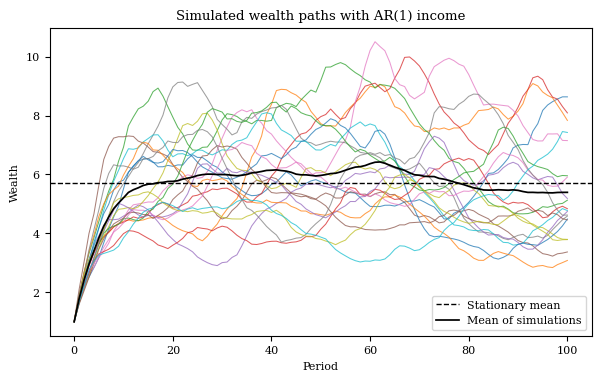

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.plot(a_sim, alpha=0.75, lw=0.75)
ax.set_xlabel('Period')
ax.set_ylabel('Wealth')
ax.set_title('Simulated wealth paths with AR(1) income')
# Add unconditional mean of wealth distribution
ax.axhline(a_mean, color='black', ls='--', lw=1, label='Stationary mean')
# Add average of simulated wealth paths
ax.plot(a_sim_mean, color='black', ls='-', lw=1.25, label='Mean of simulations')
ax.legend(loc='lower right')

The graph shows that after about 20 periods, the wealth distribution for each period is more or less centered around its stationary mean.

##### Simulating a large sample

As before, we want to simulate a much larger sample to quantify the wealth inequality in this economy.
We therefore repeat the exercise and simulate 100,000 households for 100 periods:

In [25]:
# Simulate larger sample
N = 100_000
T = 100

# Create RNG instance
rng = np.random.default_rng(seed=1234)

# Simulate the wealth paths (result is an array of shape (T+1, N))
a_sim = simulate_wealth_ar1_income(par, a0, T, N, rng)

# Mean of simulated time series
a_sim_mean = np.mean(a_sim, axis=1)

# Cross-sectional variance of simulated time series
a_sim_var = np.var(a_sim, axis=1)

##### Comparing simulated to analytical moments

As stated initially, it is no longer possible to analytically compute the variance of the cross-sectional distribution. We can still compute the exact mean using the function `compute_wealth_mean()` implemented in the module `lecture07_ar1_income`:

In [26]:
from lecture07_ar1_income import compute_wealth_mean

# Compute analytical mean
a_mean_exact = compute_wealth_mean(par)

The following plot shows the simulated mean and variance. As you can see, the cross-sectional variance also converges to some long-run value.

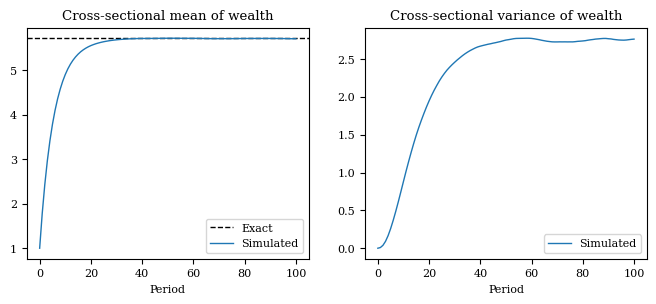

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharex=True)

# Drop initial observations to focus on convergence
t_from = 0
xvalues = np.arange(t_from, T+1)

# Plot simulated vs. analytical mean
ax1.axhline(a_mean_exact, color='black', ls='--', lw=1, label='Exact')
ax1.plot(xvalues, a_sim_mean[t_from:], lw=1, label='Simulated')
ax1.set_xlabel('Period')
ax1.set_title('Cross-sectional mean of wealth')
ax1.legend(loc='lower right')

# Plot simulated variance
ax2.plot(xvalues, a_sim_var[t_from:], lw=1, label='Simulated')
ax2.set_title('Cross-sectional variance of wealth')
ax2.set_xlabel('Period')
ax2.legend(loc='lower right')

##### Measuring wealth inequality

With the simulated cross section of 100,000 households in hand, we can again compute the Gini coefficient using
the `gini()` function from above.

In [28]:
# Select cross section from last simulated period
last_cross_section = a_sim[-1]

G = gini(last_cross_section)
print(f'Wealth Gini coefficient: {G:.3f}')

Wealth Gini coefficient: 0.160


The Gini coefficient is about 10 times larger than in the IID economy, so persistent income differences indeed increase wealth inequality. However, the magnitude of the Gini is still very far away from what we observe in the data.
As we'll see in the workshop, stochastic returns (as opposed to stochastic income) are much more potent in generating sizeable wealth inequality.

<div class="alert alert-info">
<h3> Your turn</h3>

Change the parameter <i>ρ</i> governing the persistence of income to
<ol>
    <li><i>ρ=0.5</i></li>
    <li><i>ρ=0.99</i></li>
</ol>
and rerun the code for the whole current section. What happens to average wealth in the economy and to the Gini coefficient?
</div>